# Matter-Antimatter asymmetries at the LHC

## Example program

Author: Dr Marco Gersabeck

Copyright &copy; 2020-22 The University of Manchester

### Overview
This example code follows the structure described in the lab script and depicted in the scheme below.

<img src="LabScheme.png" width="600">

### Configuration
The cell below imports all required Python modules. If you need more and add them there, make sure to execute this cell again before executing the cell requiring the new module.

In [1]:
%matplotlib inline
import uproot
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
import scipy.constants as pc
from scipy.optimize import curve_fit # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
from scipy.integrate import quad


### Input data
This opens input data files and assigns them to variables.

In [2]:
path = '../shared/' # set this to '' to run on the GitHub version
#events_sim = uproot.open(path+'PhaseSpaceSimulation.root')
events_down = uproot.open(path+'B2HHH_MagnetDown.root')
events_up = uproot.open(path+'B2HHH_MagnetUp.root')

### Select data and calculate derived quantities
The following cell reads the input data. This is where all derived quantities (such as transverse momentum) should be calculated and where selection criteria are applied (such as the z component of the momentum being positive).

In [3]:
# Check what's in the tree. 
# Note that the simulation tree is called 'PhaseSpaceTree' and does not have the ProbPi/K variables filled.
print('Input data variables:')
print(events_up['DecayTree'].keys) #events_change

#Extract all data

H1PX = [] 
H1PY = [] 
H1PZ = []  
H2PX = [] 
H2PY = []  
H2PZ = [] 
H3PX = []  
H3PY = []  
H3PZ = []  

H1C = [] 
H2C = [] 
H3C = [] 


H1_PPi = [] 
H1_PK = [] 
H2_PPi = [] 
H2_PK = [] 
H3_PPi = [] 
H3_PK = [] 

H1Muon = [] 
H2Muon = [] 
H3Muon = [] 
 

# Select which set of input data is to be analysed. Uncomment exactly one line
#trees = [events_sim['PhaseSpaceTree']]                       # Simulation
#trees = [events_down[b'DecayTree']]                          # Magnet down data
#trees = [events_up['DecayTree']]                             # Magnet up data
trees = [events_down[b'DecayTree'],events_up['DecayTree']]   # Magnet down+up data ¦¦¦  final analysis

# A counter for bookkeeping
event_counter = 0

# If set to a value greater than 0, limits the number of events analysed
# Set to -1 to run over all events. 
# It is recommended to keep the number of events limited while developing the analysis.
MAX_EVENTS = -1

# This loop goes over the trees to be analysed
for tree in trees:
      # This outer loop is a technical loop of uproot over chunks of events
    for data in tree.iterate([b'H*_P[XYZ]',b'H*_Charge',b'H*_Prob*',b'H*_isMuon']):
        # As Python can handle calculations with arrays, we can calculate derived quantities here 
        event_counter = len(H1PX)
        if 0 <= MAX_EVENTS and MAX_EVENTS < event_counter: break
        if 0 == (event_counter % 10): print('Read', event_counter, 'events')
            
  
        H1PX = np.concatenate((H1PX, data[b'H1_PX']))
        H1PY = np.concatenate((H1PY, data[b'H1_PY']))
        H1PZ = np.concatenate((H1PZ, data[b'H1_PZ']))
        H2PX = np.concatenate((H2PX, data[b'H2_PX']))
        H2PY = np.concatenate((H2PY, data[b'H2_PY']))
        H2PZ = np.concatenate((H2PZ, data[b'H2_PZ']))
        H3PX = np.concatenate((H3PX, data[b'H3_PX']))
        H3PY = np.concatenate((H3PY, data[b'H3_PY']))
        H3PZ = np.concatenate((H3PZ, data[b'H3_PZ']))

        H1C = np.concatenate((H1C, data[b'H1_Charge']))
        H2C = np.concatenate((H2C, data[b'H2_Charge']))
        H3C = np.concatenate((H3C, data[b'H3_Charge']))

        H1_PPi = np.concatenate((H1_PPi, data[b'H1_ProbPi']))
        H1_PK = np.concatenate((H1_PK, data[b'H1_ProbK']))
        H2_PPi = np.concatenate((H2_PPi, data[b'H2_ProbPi']))
        H2_PK = np.concatenate((H2_PK, data[b'H2_ProbK']))
        H3_PPi = np.concatenate((H3_PPi, data[b'H3_ProbPi']))
        H3_PK = np.concatenate((H3_PK, data[b'H3_ProbK']))

        H1Muon = np.concatenate((H1Muon, data[b'H1_isMuon']))
        H2Muon = np.concatenate((H2Muon, data[b'H2_isMuon']))
        H3Muon = np.concatenate((H3Muon, data[b'H3_isMuon'])) 

#print(len(H1PX))
print('Read', len(H1_PPi), 'total events')

Input data variables:
<bound method TTreeMethods.keys of <TTree b'DecayTree' at 0x7fc7541ea3d0>>
Read 0 events
Read 231420 events
Read 462840 events
Read 694260 events
Read 925680 events
Read 1157100 events
Read 1388520 events
Read 1619940 events
Read 1851360 events
Read 2082780 events
Read 2314200 events
Read 2545620 events
Read 2777040 events
Read 3008460 events
Read 3239880 events
Read 3471300 events
Read 3702720 events
Read 3934140 events
Read 4165560 events
Read 4396980 events
Read 4628400 events
Read 4859820 events
Read 5091240 events
Read 8556118 total events


In [4]:
#Sorts the probabilities of pions and kaons and then selects the data appropriately

def IntersecOfSets(arr1, arr2, arr3, arr4, arr5):
    # Converting the arrays into sets 
    #https://www.geeksforgeeks.org/python-program-find-common-elements-three-lists-using-sets/
    s1 = set(arr1[0].flatten())
    s2 = set(arr2[0].flatten())
    s3 = set(arr3[0].flatten())
    s4 = set(arr4[0].flatten())
    s5 = set(arr5[0].flatten())
    
    set1 = s1.intersection(s2)       
    set2 = set1.intersection(s3)
    set3 = set2.intersection(s4)  
    result_set = set3.intersection(s5)      
 
    final_set = np.array(list(result_set))
 
    return final_set

sort_pi = np.sort(np.array([H1_PPi, H2_PPi, H3_PPi]), axis=0)
sort_k = np.sort(np.array([H1_PK, H2_PK, H3_PK]), axis=0)


indices_muon = np.where((H1Muon == 0) & (H2Muon == 0) & (H3Muon == 0)) # Indices of data points which are not muons
indices_neg_vals = np.where((H1PZ >= 0) & (H2PZ >= 0) & (H3PZ >= 0)) # Indices of data points which have no -ve momentum values

indices_pi = np.where((sort_pi[0] > 0.75) & (sort_pi[1] > 0.75) & (sort_pi[2] > 0.75)) 
# Indices of data points which satisfy ProbPi chosen values (above a certain threshold) --- Vary
indices_k = np.where((sort_k[0] < 0.05) & (sort_k[1] < 0.05) & (sort_k[2] < 0.05)) 
# Indices of data points which satisfy ProbK chosen values (below a certain threshold) --- Vary
indices_pi3 = np.where((sort_pi[0] + sort_pi[1] + sort_pi[2] > 1.9)) 
# Indices of data points which satisfy sum of Prob Pi (above a certain threshold) --- Vary


# #No sort
# indices_pi = np.where((H1_PPi > 0.6) & (H2_PPi > 0.6) & (H3_PPi > 0.6)) 
# # Indices of data points which satisfy ProbPi chosen values (above a certain threshold) --- Vary
# indices_k = np.where((H1_PK < 0.1) & (H2_PK < 0.1) & (H3_PK < 0.1)) 
# # Indices of data points which satisfy ProbK chosen values (below a certain threshold) --- Vary
# indices_pi3 = np.where((H1_PPi + H2_PPi + H3_PPi > 2.0)) 
# # Indices of data points which satisfy sum of Prob Pi (above a certain threshold) --- Vary


# print(len(indices_pi[0]))
# print(len(indices_k[0]))
# print(len(indices_pi3[0]))
# print(len(indices_muon[0]))
# print(len(indices_neg_vals[0]))

indices = IntersecOfSets(indices_muon, indices_neg_vals, indices_pi, indices_k, indices_pi3) #Finds all indices which match up
H1PX_sel = H1PX[indices]
H1PY_sel = H1PY[indices] 
H1PZ_sel = H1PZ[indices]  
H2PX_sel = H2PX[indices] 
H2PY_sel = H2PY[indices]  
H2PZ_sel = H2PZ[indices] 
H3PX_sel = H3PX[indices]  
H3PY_sel = H3PY[indices]  
H3PZ_sel = H3PZ[indices]  

H1C_sel = H1C[indices] 
H2C_sel = H2C[indices] 
H3C_sel = H3C[indices] 

H1_PPi_sel = H1_PPi[indices] 
H1_PK_sel = H1_PK[indices] 
H2_PPi_sel = H2_PPi[indices] 
H2_PK_sel = H2_PK[indices] 
H3_PPi_sel = H3_PPi[indices] 
H3_PK_sel = H3_PK[indices] 

# print(H1PZ[2])
# print(H2PZ[2])
# print(H3PZ[2])
# print(H1Muon[2])
# print(H2Muon[2])
# print(H3Muon[2])

In [5]:
print(sort_k[0][indices_k])
print(len(indices))

[0.00297898 0.00227505 0.00327393 ... 0.00951499 0.00448883 0.00679082]
115263


In [6]:
#Invariant mass calculations


MASS = 139.57039 # of pion   
MASS_SQ = MASS ** 2

def energy_calc(p_initial):
    
    energy = 0
    for i in range(0, len(p_initial)):
        energy += np.sqrt(p_initial[i] + MASS_SQ)

    return energy

def p_particle(p1, p2, p3):

    return p1 ** 2 + p2 ** 2 + p3 ** 2


def inv_mass_calc(e, p):
    # e - energy
    # p - momentum
    return e ** 2 - (p[0] ** 2 + p[1] ** 2 + p[2] ** 2)

#3 body invariant mass

p1_sq = p_particle(H1PX_sel, H1PY_sel, H1PZ_sel)# the total momentum of each individual particle
p2_sq = p_particle(H2PX_sel, H2PY_sel, H2PZ_sel)
p3_sq = p_particle(H3PX_sel, H3PY_sel, H3PZ_sel)

px = H1PX_sel + H2PX_sel + H3PX_sel # the total momentum of the 3 particles in each direction
py = H1PY_sel + H2PY_sel + H3PY_sel
pz = H1PZ_sel + H2PZ_sel + H3PZ_sel

energy = energy_calc(np.array([p1_sq, p2_sq, p3_sq])) # input array is total momentum of each particle
inv_mass = np.sqrt(inv_mass_calc(energy, np.array([px, py, pz]))) # input array is total momentum in each spatial direction

#-----------------------------
#2 body invariant mass

px12 = H1PX_sel + H2PX_sel
px13 = H1PX_sel + H3PX_sel
px23 = H2PX_sel + H3PX_sel

py12 = H1PY_sel + H2PY_sel 
py13 = H1PY_sel + H3PY_sel
py23 = H2PY_sel + H3PY_sel

pz12 = H1PZ_sel + H2PZ_sel
pz13 = H1PZ_sel + H3PZ_sel
pz23 = H2PZ_sel + H3PZ_sel
                   

energy12 = energy_calc(np.array([p1_sq, p2_sq]))
inv_mass12 = np.sqrt(inv_mass_calc(energy12, np.array([px12, py12, pz12])))

energy13 = energy_calc(np.array([p1_sq, p3_sq]))
inv_mass13 = np.sqrt(inv_mass_calc(energy13, np.array([px13, py13, pz13])))

energy23 = energy_calc(np.array([p2_sq, p3_sq]))
inv_mass23 = np.sqrt(inv_mass_calc(energy23, np.array([px23, py23, pz23])))

print(len(inv_mass12))
print(len(inv_mass13))
print(len(inv_mass23))

115263
115263
115263


115263


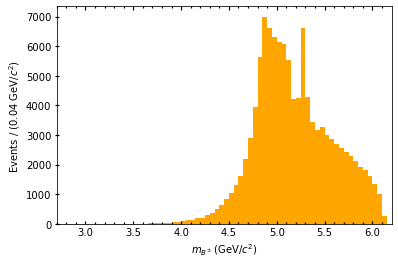

In [7]:
#PLot of invariant mass
fig, ax = plt.subplots()
fig.set_facecolor("white")
ax.hist(inv_mass / 1000, bins=70, color= 'orange', range=[2.7, 6.2])
ax.set_xlabel(r'$m_{B^{\pm}}$ (GeV/$c^{2}$)')
ax.set_ylabel('Events / (0.04 GeV/$c^{2}$) ')
ax.set_xticks(ticks=np.arange(2.7, 6.2, step=0.1), minor=True)
#ax.set_yticks(ticks=np.arange(0, 20000, step=500), minor=True)
ax.set_xlim(2.7,6.2)


ax.xaxis.set_tick_params(width=1.2, which='both', direction='in', bottom=True, top=True)
ax.yaxis.set_tick_params(width=1.2, which='both', direction='inout')
#ax.grid(axis="both", color="black", alpha=.3, linewidth=2, linestyle=":")
#ax.set_title('Probability density of B meson') # initial selection


#fig.savefig('B meson invariant mass cut.pdf')
#fig.savefig('B meson invariant mass cut.png', dpi=600)
print(len(inv_mass))
#https://stackoverflow.com/questions/5821895/matplotlib-histogram-frequency-as-thousands

In [8]:
#Separation of higher and lower 2 body invariant mass
# indices_higher12 = np.where((inv_mass12 > inv_mass13)) 
# indices_higher13 = np.where((inv_mass13 > inv_mass12)) 

inv_big = np.zeros((len(inv_mass)))
inv_small = np.zeros((len(inv_mass)))

for i in range(0, len(inv_mass)):
    if inv_mass12[i] > inv_mass13[i]:
        inv_big[i] = inv_mass12[i]
        inv_small[i] = inv_mass13[i]
    else:
        inv_big[i] = inv_mass13[i]
        inv_small[i] = inv_mass12[i]

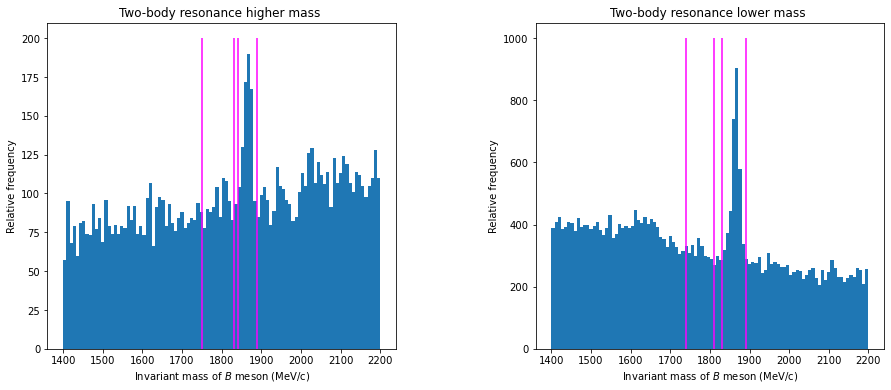

In [9]:
#Visualise where to cut out D0 points
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.4)
ax[0].hist(inv_big, bins=100, range=[1400,2200]) 
ax[0].set_xlabel('Invariant mass of $B$ meson (MeV/c)')
ax[0].set_ylabel('Relative frequency')
ax[0].set_title(r'Two-body resonance higher mass ')
ax[0].vlines([1750, 1830, 1840, 1890], 0, 200, color='fuchsia') #vary ranges

ax[1].hist(inv_small, bins=100, range=[1400,2200]) 
ax[1].set_xlabel('Invariant mass of $B$ meson (MeV/c)')
ax[1].set_ylabel('Relative frequency')
ax[1].set_title(r'Two-body resonance lower mass ')
ax[1].vlines([1740, 1810, 1830, 1890], 0, 1000, color='fuchsia') #vary ranges
#plt.savefig('D0 removal.pdf')


In [10]:
#Cutting out D0 points
def combine(list1, list2):
    # https://www.adamsmith.haus/python/answers/how-to-combine-two-lists-while-removing-duplicates-in-the-new-list-and-keeping-duplicates-in-original-list-in-python
    # https://datagy.io/python-intersection-between-lists/
    # https://datagy.io/python-combine-lists/ 
    set_1 = set(list1[0].flatten())
    set_2 = set(list2[0].flatten())

    final_list = list(set_1.intersection(set_2))
    return np.array(final_list)

indices_d0_big = np.where((inv_big <= 1750) | (inv_big >= 1890) | ((1830 <= inv_big) & (inv_big <= 1840)))
indices_d0_small = np.where((inv_small <= 1740) | (inv_small >= 1890) | ((1810 <= inv_small) & (inv_small <= 1830)))
#check this is right
inv_big_c1 = inv_big[indices_d0_big[0]]
inv_small_c1 = inv_small[indices_d0_small[0]]


indices_all = combine(indices_d0_big, indices_d0_small)
# print(len(indices_all))
# print(len(indices_d0_big[0]))
# print(len(indices_d0_small[0]))

inv_mass_c1 = inv_mass[indices_all]
inv_big_cut = inv_big[indices_all]
inv_small_cut = inv_small[indices_all]

H1C_c1 = H1C_sel[indices_all]
H2C_c1 = H2C_sel[indices_all]
H3C_c1 = H3C_sel[indices_all]

print(len(inv_big))
print(len(inv_mass))
print(np.where((1750 <= inv_big_cut) & (inv_big_cut <= 1830)))
print('Number of data points removed because of D0, resonance, =',len(inv_mass) - len(inv_mass_c1))

#Combining indices of small and big invariant mass for which to cut out in main invariant mass

115263
115263
(array([], dtype=int64),)
Number of data points removed because of D0, resonance, = 8311


Text(0.5, 1.0, 'Initial selection minus $D_{0}$ zoomed in')

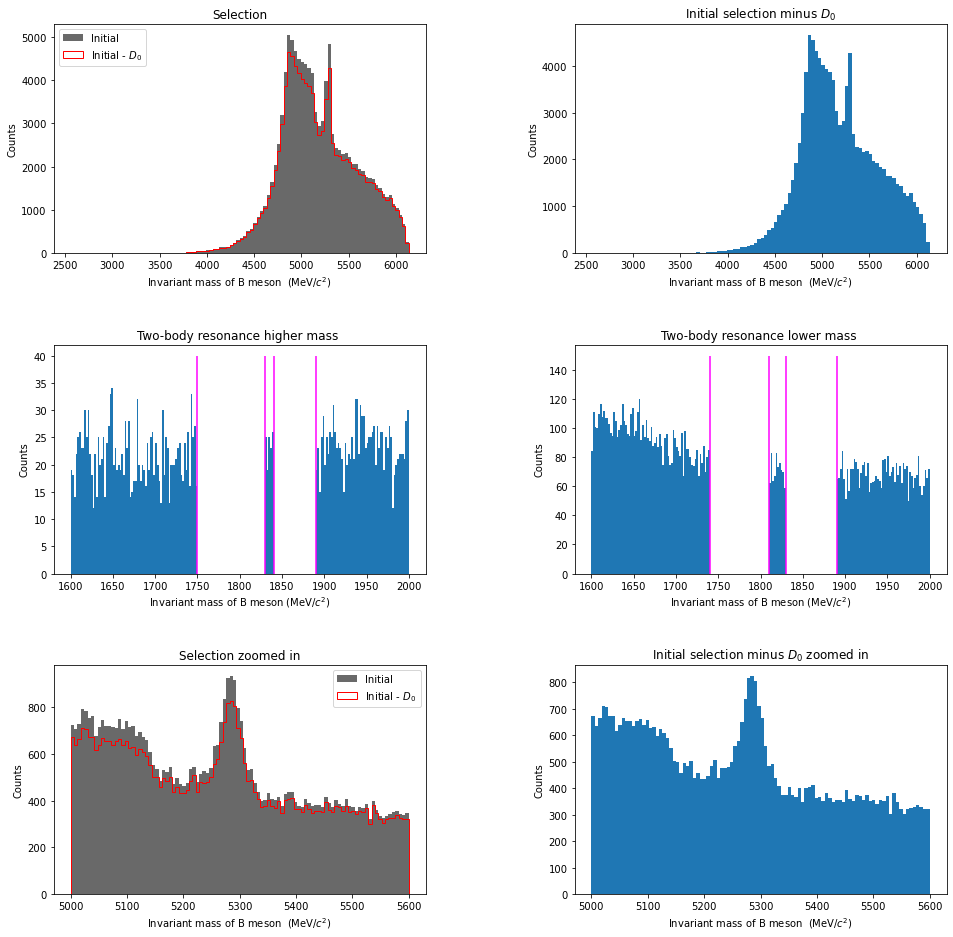

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
fig.subplots_adjust(wspace=0.4, hspace = 0.4)

ax[0][0].hist(inv_mass, bins=100, label='Initial', color='dimgray')
ax[0][0].hist(inv_mass_c1, bins=100, histtype='step', color='red', label=r'Initial - $D_{0}$')# 
ax[0][0].set_xlabel('Invariant mass of B meson  (MeV/$c^{2}$)')
ax[0][0].set_ylabel('Counts')
ax[0][0].set_title('Selection')
ax[0][0].legend(loc='upper left')
# plt.savefig('invariant_mass.png')

ax[0][1].hist(inv_mass_c1, bins=100) # 
ax[0][1].set_xlabel('Invariant mass of B meson  (MeV/$c^{2}$)')
ax[0][1].set_ylabel('Counts')
ax[0][1].set_title('Initial selection minus $D_{0}$')

ax[1][0].hist(inv_big_c1, bins=200, range=[1600,2000]) 
ax[1][0].set_xlabel('Invariant mass of B meson (MeV/$c^{2}$)')
ax[1][0].set_ylabel('Counts')
ax[1][0].set_title(r'Two-body resonance higher mass ')
ax[1][0].vlines([1750, 1830, 1840, 1890], 0, 40, color='fuchsia') #vary ranges
#plt.savefig('High invariant mass D0 removed.png')

ax[1][1].hist(inv_small_c1, bins=200, range=[1600,2000]) 
ax[1][1].set_xlabel('Invariant mass of B meson (MeV/$c^{2}$)')
ax[1][1].set_ylabel('Counts')
ax[1][1].set_title(r'Two-body resonance lower mass ')
ax[1][1].vlines([1740, 1810, 1830, 1890], 0, 150, color='fuchsia') #vary ranges


ax[2][0].hist(inv_mass, range=[5000, 5600], bins=100, label='Initial', color='dimgray') # 
ax[2][0].hist(inv_mass_c1, range=[5000, 5600], bins=100,  histtype='step', label=r'Initial - $D_{0}$', color='red') # 
ax[2][0].set_xlabel('Invariant mass of B meson  (MeV/$c^{2}$)')
ax[2][0].set_ylabel('Counts')
ax[2][0].set_title('Selection zoomed in')
ax[2][0].legend()

ax[2][1].hist(inv_mass_c1, range=[5000, 5600], bins=100) # 
ax[2][1].set_xlabel('Invariant mass of B meson  (MeV/$c^{2}$)')
ax[2][1].set_ylabel('Counts')
ax[2][1].set_title('Initial selection minus $D_{0}$ zoomed in')

#plt.savefig('Invariant mass D0 removed.pdf')

115263


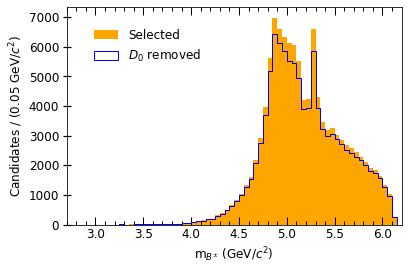

In [12]:
#PLot of invariant mass
fig, ax = plt.subplots()
fig.set_facecolor("white")
ax.hist(inv_mass / 1000, bins=70, color= 'orange', range=[2.7, 6.2], label='Selected')
ax.hist(inv_mass_c1 / 1000, bins=70, histtype='step', color='blue', range=[2.7, 6.2], label=r'$D_{0}$ removed')# 
ax.set_xlabel(r'$ \mathrm{m}_{B^{\pm}}$ (GeV/$c^{2}$)',size='large')
ax.set_ylabel('Candidates / (0.05 GeV/$c^{2}$) ',size='large')
ax.set_xticks(ticks=np.arange(2.7, 6.2, step=0.1), minor=True)
#ax.set_yticks(ticks=np.arange(0, 20000, step=500), minor=True)
ax.set_xlim(2.7,6.2)


ax.xaxis.set_tick_params(width=1, which='major', direction='in', bottom=True, top=True, length=8, labelsize='large')
ax.xaxis.set_tick_params(width=1, which='minor', direction='in', bottom=True, top=True, length=4)

ax.yaxis.set_tick_params(width=1.2, which='major', direction='inout', length=8, labelsize='large')
ax.yaxis.set_tick_params(width=1.2, which='minor', direction='inout', length=4)

#ax.grid(axis="both", color="black", alpha=.3, linewidth=2, linestyle=":")
#ax.set_title('Probability density of B meson') # initial selection
leg = plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(0.05, 0.95), fontsize='large')
#leg.legendHandles[0].set_alpha(.9)
#fig.savefig('B meson invariant mass cut.pdf')
#fig.savefig('B meson invariant mass cut.png', dpi=600)
print(len(inv_mass))
#https://stackoverflow.com/questions/5821895/matplotlib-histogram-frequency-as-thousands

Text(0.5, 1.0, 'Two-body resonance lower mass cut')

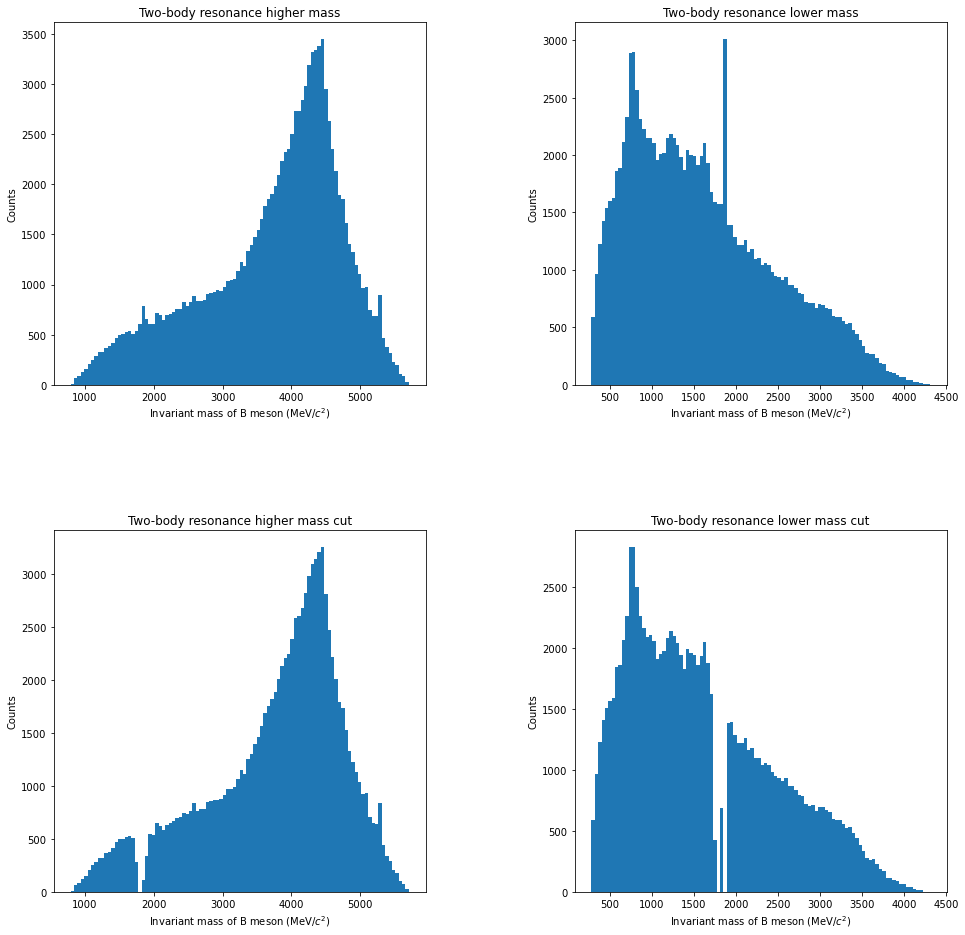

In [13]:
#PLot of large and small invariant mass before and after data cut
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
fig.subplots_adjust(wspace=0.4, hspace = 0.4)

ax[0][0].hist(inv_big, bins=100)
ax[0][0].set_xlabel('Invariant mass of B meson (MeV/$c^{2}$)')
ax[0][0].set_ylabel('Counts')
ax[0][0].set_title(r'Two-body resonance higher mass')

ax[0][1].hist(inv_small, bins=100)
ax[0][1].set_xlabel('Invariant mass of B meson (MeV/$c^{2}$)')
ax[0][1].set_ylabel('Counts')
ax[0][1].set_title(r'Two-body resonance lower mass')


ax[1][0].hist(inv_big_cut, bins=100)#, range=[1600,2000]) 
ax[1][0].set_xlabel('Invariant mass of B meson (MeV/$c^{2}$)')
ax[1][0].set_ylabel('Counts')
ax[1][0].set_title(r'Two-body resonance higher mass cut')

ax[1][1].hist(inv_small_cut, bins=100)#, range=[1600,2000]) 
ax[1][1].set_xlabel('Invariant mass of B meson (MeV/$c^{2}$)')
ax[1][1].set_ylabel('Counts')
ax[1][1].set_title(r'Two-body resonance lower mass cut')

#Reason why for higher mass you only see 1 space is because of the number of bins
# they still cover the lower range just not as strongly
#plt.savefig('Full scale two-body comparison.pdf')


Text(0.5, 1.0, 'Two-body resonance higher mass')

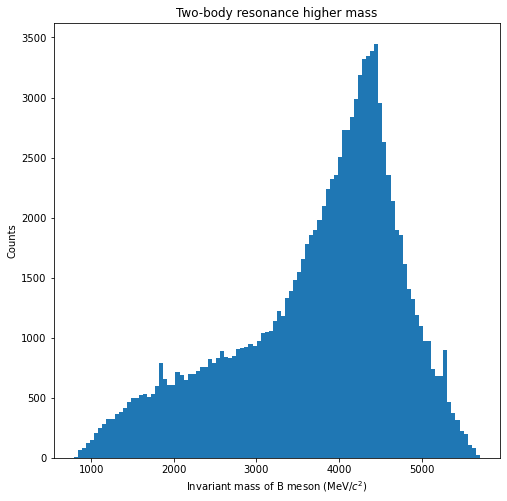

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
fig.subplots_adjust(wspace=0.4, hspace = 0.4)

ax.hist(inv_big, bins=100)
ax.set_xlabel('Invariant mass of B meson (MeV/$c^{2}$)')
ax.set_ylabel('Counts')
ax.set_title(r'Two-body resonance higher mass')

#plt.savefig('Full scale two-body high mass.png', dpi=600)

Text(0.5, 1.0, 'Two-body resonance higher mass')

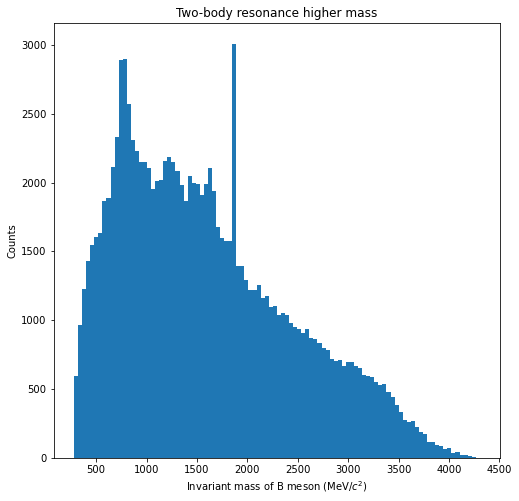

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
fig.subplots_adjust(wspace=0.4, hspace = 0.4)

ax.hist(inv_small, bins=100)
ax.set_xlabel('Invariant mass of B meson (MeV/$c^{2}$)')
ax.set_ylabel('Counts')
ax.set_title(r'Two-body resonance higher mass')

#plt.savefig('Full scale two-body low mass.png', dpi=600)

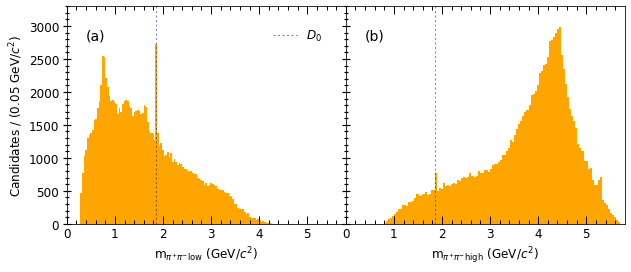

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)
fig.subplots_adjust(wspace=0)
fig.set_facecolor("white")


ax1.hist(inv_small / 1000, bins=116, color= 'orange')
ax1.set_xlabel(r'$\mathrm{m}_{\pi^{+} \pi^{-} \mathrm{low}}$ (GeV/$c^{2}$)', size='large')
ax1.set_ylabel(r'Candidates / (0.05 GeV/$c^{2}$)', size='large') # add per xxx
ax1.set_xlim(0,5.8)
ax1.set_ylim(0,3300)
ax1.set_xticks(ticks=np.arange(0, 5.8, step=0.2), minor=True)
ax1.minorticks_on()
ax1.xaxis.set_tick_params(width=1, which='major', direction='in', bottom=True, top=True, length=8, labelsize='large')
ax1.xaxis.set_tick_params(width=1, which='minor', direction='in', bottom=True, top=True, length=4)
ax1.yaxis.set_tick_params(width=1.2, which='major', direction='inout', length=8, labelsize='large')
ax1.yaxis.set_tick_params(width=1.2, which='minor', direction='inout', length=4)
ax1.text(0.4, 2800, '(a)', fontsize=14)
ax1.axvline(1.864,0, 1, color='darkblue', dashes=[4,5], alpha=1, linewidth=0.5, label=r'$D_{0}$')


ax2.hist(inv_big / 1000, bins=116, color= 'orange')
ax2.set_xlabel(r'$\mathrm{m}_{\pi^{+} \pi^{-} \mathrm{high}}$ (GeV/$c^{2}$)', size='large')
ax2.set_xlim(0,5.8)
ax2.set_ylim(0,3300)
ax2.minorticks_on()
ax2.set_xticks(ticks=np.arange(0, 5.8, step=0.2), minor=True)
ax2.xaxis.set_tick_params(width=1, which='major', direction='in', bottom=True, top=True, length=8, labelsize='large')
ax2.xaxis.set_tick_params(width=1, which='minor', direction='in', bottom=True, top=True, length=4)
ax2.yaxis.set_tick_params(width=1.2, which='major', direction='inout', length=8, labelsize='large')
ax2.yaxis.set_tick_params(width=1.2, which='minor', direction='inout', length=4)
ax2.text(0.4, 2800, '(b)', fontsize=14)
ax2.axvline(1.864,0, 1, color='darkblue', dashes=[4,5], alpha=1, linewidth=0.5)

ax1.legend(frameon=False, loc='upper left', bbox_to_anchor=(0.7, 0.95), fontsize='large')

#fig.savefig('B meson invariant mass cut.pdf')
#fig.savefig('2-body invariant mass pairs', dpi=600)

In [17]:
print(len(inv_big_cut))
print(len(inv_small_cut))
print(len(inv_big))
print(len(inv_small))
print(len(inv_big)-len(inv_big_cut))

106952
106952
115263
115263
8311


In [18]:
#Separate Antimatter and Matter
indices_matter = np.where(H1C_c1 < 0)
indices_antimatter = np.where(H1C_c1 > 0)

inv_mass_matter = inv_mass_c1[indices_matter]
inv_mass_antimatter = inv_mass_c1[indices_antimatter]

inv_big_m = inv_big_cut[indices_matter]
inv_small_m = inv_small_cut[indices_matter]
inv_big_am = inv_big_cut[indices_antimatter]
inv_small_am = inv_small_cut[indices_antimatter]
print(len(inv_big_m))
print(len(inv_small_m))
print(len(inv_big_am))
print(len(inv_small_am))

53266
53266
53686
53686


### Visualise data
The cell below produces histograms of the data contained in the arrays that were filled in the cell above.

Plotting 2D histogram


(0.7, 1.0)

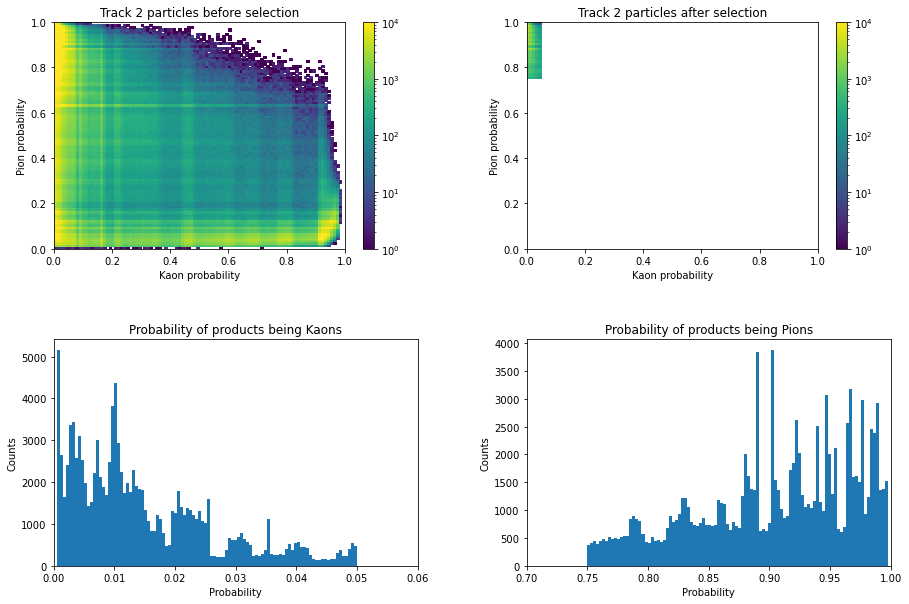

In [20]:
# Plot some histograms -- NOTE: this can take several minutes

# This line produces two plots side-by-side. 
# It's still useful just for one plot as you can set the size and get the fig,ax objects
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(wspace=0.3, hspace = 0.4) # increase horizontal space between plots

h2d_initial = ax[0][0].hist2d(H2_PK, H2_PPi, bins = [100,100], range = [[0,1],[0,1]],norm=colors.LogNorm(vmin=1, vmax=10 ** 4))
ax[0][0].set_xlabel('Kaon probability')
ax[0][0].set_ylabel('Pion probability')
ax[0][0].set_title('Track 2 particles before selection')
fig.colorbar(h2d_initial[3],ax=ax[0][0]) # let's add the colour scale
ax[0][0].yaxis.set_tick_params(labelright=False)


# This plots a 2D-histogram with values converted to GeV and with a logarithmic colour scale
print('Plotting 2D histogram')
h2d = ax[0][1].hist2d(H2_PK_sel, H2_PPi_sel, bins = [100,100], range = [[0,1],[0,1]],norm=colors.LogNorm(vmin=1, vmax=10 ** 4))
ax[0][1].set_xlabel('Kaon probability')
ax[0][1].set_ylabel('Pion probability')
ax[0][1].set_title('Track 2 particles after selection')
fig.colorbar(h2d[3],ax=ax[0][1]) # let's add the colour scale
ax[0][1].yaxis.set_tick_params(labelright=False)


ax[1][0].hist(H2_PK_sel, bins=100)
ax[1][0].set_xlabel('Probability')
ax[1][0].set_ylabel('Counts')
ax[1][0].set_title('Probability of products being Kaons')
ax[1][0].set_xlim([0,0.06])

ax[1][1].hist(H2_PPi_sel, bins=100)
ax[1][1].set_xlabel('Probability')
ax[1][1].set_ylabel('Counts')
ax[1][1].set_title('Probability of products being Pions')
ax[1][1].set_xlim([0.7,1])
#plt.savefig('Probabilities selection.pdf')

Plotting 1D histogram


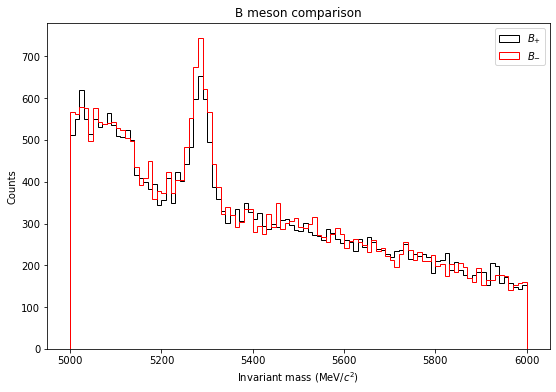

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))

# This plots two 1D-histograms.
print('Plotting 1D histogram')
mvalues_pT_not_norm,mbins_pT,mpatches_pT = ax.hist(inv_mass_matter, bins = 100, range=[5000, 6000], color='black',
                                             histtype='step',label=r'$B_{+}$')
amvalues_pT_not_norm,ambins_pT,ampatches_pT = ax.hist(inv_mass_antimatter, bins = 100, range=[5000, 6000], color='red', 
              histtype='step', label=r'$B_{-}$')
ax.set_xlabel('Invariant mass (MeV/$c^{2}$)')
ax.set_ylabel('Counts')
ax.set_title('B meson comparison')
ax.legend()

mvalues_pT = mvalues_pT_not_norm /(mbins_pT[1] - mbins_pT[0])
amvalues_pT = amvalues_pT_not_norm /(ambins_pT[1] - ambins_pT[0])
#plt.savefig('B meson comparison.pdf')

In [22]:
print(len(mvalues_pT))
print(len(mbins_pT))
print(len(amvalues_pT))
print(len(ambins_pT))

data = np.vstack((mvalues_pT, amvalues_pT))
bins = np.vstack((mbins_pT, ambins_pT))
print((mbins_pT[1] - mbins_pT[0]))
print((ambins_pT[1] - ambins_pT[0]))
# np.savetxt('data.txt', data, delimiter = ',')
# np.savetxt('bins.txt', bins, delimiter = ',')

100
101
100
101
10.0
10.0


### Fitting data

The following code shows how to fit a function to a dataset. The fit function is a sum of two functions, which can be extended to more complex functions. The output includes a chi2 calculation and plotting and saving of the resulting histogram.

$B_{+}$ 

Fit results with chi2/ndf 65.59178564220058 / 60
Par 1: 3175.774418 +/- 2470.607543
Par 2: 1169.464719 +/- 195.783558
Par 3: 14.088101 +/- 2.283059
Par 4: 5061.829522 +/- 6.723206
Par 5: 3698.348705 +/- 1335.333070
Par 6: 29.822320 +/- 1.744529
Par 7: 5284.896799 +/- 1.100570
Par 8: 301.052722 +/- 44.177460
Reduced chi-square is 1.0931964273700097
-------------------------------------------------------------------------
$B_{-}$ 

Fit results with chi2/ndf 77.3209137986035 / 60
Par 1: 882.612617 +/- 980.956288
Par 2: 1615.603416 +/- 531.089322
Par 3: 17.638875 +/- 3.335139
Par 4: 5045.734230 +/- 12.735565
Par 5: 7376.275440 +/- 2711.005157
Par 6: 37.072097 +/- 1.740599
Par 7: 5284.559635 +/- 1.002859
Par 8: 400.006375 +/- 46.657672
Reduced chi-square is 1.2886818966433917


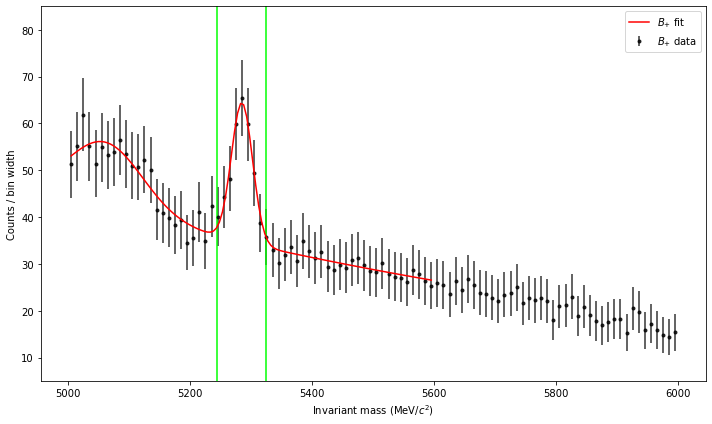

In [23]:
def exponential(x, norm, decay):
    # decaying exponential function
    #mean = 6400
    return np.array(norm * np.exp(-x / decay))

def gauss_1(x, norm, mean, sd):
    # First gaussian
    #mean = 5000
    return np.array( norm * np.exp(-(x-mean) ** 2/(2 * sd)))

def gauss_main(x, norm, mean, sd):
    #Second gaussian - important peak
    
    return np.array( norm * np.exp(-(x-mean) ** 2/(2 * sd)))
    
# fit function combining two individual functions
def fit_function(x, normE, decay, normG1, meanG1, sd1, normG2, meanG2, sd2):
    return np.array( exponential(x, normE, decay) + gauss_1(x, normG1, meanG1, sd1) + gauss_main(x, normG2, meanG2, sd2))
    
def fit_data(bins, values, minX, maxX, p0):
    # determine bin centres
    bin_centres = [(a+b)/2 for a,b in zip(bins[0:-1],bins[1:]) ] # uses simultaneous loop over two arrays

    # reduce range to fit only part of curve
    bin_centres_red = [] 
    values_red = []

    for c,v in zip(bin_centres,values):
        if c < minX or c > maxX: continue
        bin_centres_red.append(c)
        values_red.append(v)

    # execute the fit with starting values as given in p0
    coeff_fit,cov_fit = curve_fit(fit_function,bin_centres_red,values_red,p0, maxfev = 100000000) # fit
    
    # evaluate chi2
    fit_vals = [fit_function(x,coeff_fit[0],coeff_fit[1],coeff_fit[2], coeff_fit[3], 
                             coeff_fit[4], coeff_fit[5], coeff_fit[6], coeff_fit[7]) for x in bin_centres_red]
    chi2parts = np.array( ( np.divide( np.array(values_red) - np.array(fit_vals), np.sqrt( values_red ), 
                                      out = np.array(values_red), where = np.array(values_red) != 0 ) )**2 )
    # understand what this returns
    chi2 = np.sum(chi2parts) * (bins[1] - bins[0]) # multiply by bin width to fix
   
    return coeff_fit,cov_fit, bin_centres, bin_centres_red, chi2, len(chi2parts)

def print_results(coeff,cov,chi2,ndf,label):
   
    perr = np.sqrt(np.diag(cov)) # extract errors from covariance matrix
    
    print(label,'\n')
    print('Fit results with chi2/ndf', chi2,'/',ndf)
    parcount = 0
    for p,e in zip(coeff,perr):
        parcount += 1
        print('Par {:d}: {:f} +/- {:f}'.format(parcount,p,e))

    print('Reduced chi-square is {0}'. format(chi2/ndf))
    
    
def plot_results(a,bin_centres,bin_centres_red,values,coeff_fit,fname,colour,labels):
    # plot the data, this time as dots with error bars (sqrt(N) errors)
    a.errorbar(bin_centres,values,yerr=np.sqrt(values),linestyle='',marker='.',
               markerfacecolor=colour[0],markeredgecolor=colour[0],ecolor=colour[0],label=labels[0],alpha=0.8)

    # plot the fit: create x values, then calculate the corresponding y values and plot
    x_fit = np.linspace(bin_centres_red[0],bin_centres_red[-1],120)
    y_fit = fit_function(x_fit,coeff_fit[0],coeff_fit[1],coeff_fit[2], coeff_fit[3], coeff_fit[4], 
                         coeff_fit[5], coeff_fit[6], coeff_fit[7])
    a.plot(x_fit,y_fit,label=labels[1],color=colour[1],zorder=10) # zorder makes sure the fit line is on top
    
    #plt.axvline(meanm + 2 * sdm, color='lime')
    #plt.axvline(meanm - 2 * sdm, color='lime')
    
    plt.axvline(meanam + 2 * sdam, color='lime')
    plt.axvline(meanam - 2 * sdam, color='lime')
    # plot decoration
    
    a.set_xlabel('Invariant mass (MeV/$c^{2}$)')
    a.set_ylabel('Counts / bin width') # Center of each bin taken as data point
    a.set_ylim(5, 85)
    
    
    #plt.savefig(fname) #Use for individual plots
    #plt.savefig('Combined B mesons.pdf')
    a.legend()
    plt.tight_layout()
    plt.savefig('B- meson and sd.pdf', dpi=600, bbox_inches = "tight")
# Matter fit    
mcoeff_pT,mcov_pT, mbin_centres_pT, mbin_centres_red_pT, mchi2_pT, mndf_pT = fit_data(mbins_pT, mvalues_pT, 5000, 5600, 
                                                                                      [3500, 1200, 
                                                                                      15, 5080, 3600, 
                                                                                      30, 5280, 300])
amcoeff_pT,amcov_pT, ambin_centres_pT, ambin_centres_red_pT, amchi2_pT, amndf_pT = fit_data(ambins_pT, amvalues_pT, 5000, 5600, 
                                                                                            [900, 1600, 
                                                                                            18, 5000, 7300, 
                                                                                            36, 5280, 400])

#matter trial values decent [600, 1330, 2300, 19000, 560, 5280, 800] )
#antimatter trial values decent [600, 1330, 2300, 19000, 560, 5280, 800] )
meanm = mcoeff_pT[6]
sdm = np.sqrt(mcoeff_pT[7]) 
meanam = amcoeff_pT[6]
sdam = np.sqrt(amcoeff_pT[7])

print_results(mcoeff_pT, mcov_pT, mchi2_pT, mndf_pT,label=r'$B_{+}$')
print('---------------------------------------------------------'
          '----------------')
print_results(amcoeff_pT, amcov_pT, amchi2_pT, amndf_pT,label=r'$B_{-}$')

# plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plot_results(ax,np.array(mbin_centres_pT),mbin_centres_red_pT,mvalues_pT,mcoeff_pT,'B plus.pdf',
            colour=['black','red'],labels=[r'$B_{+}$ data', r'$B_{+}$ fit'])
#plot_results(ax,ambin_centres_pT,ambin_centres_red_pT,amvalues_pT ,amcoeff_pT,'B minus.pdf',
            #colour=['black','red'],labels=[r'$B_{-}$ data', r'$B_{-}$ fit'])
#same range

# plt.axvline(meanm + 2 * sdm, color='lime')
# plt.axvline(meanm - 2 * sdm, color='lime')

# plt.axvline(meanam + 2 * sdam, color='gold')
# plt.axvline(meanam - 2 * sdam, color='gold')
#plt.axvline(5230, color='red')

# This gives bad values for param 5 because we are trying to describe the 1st peak using a gaussian but the data only
# covers half the gaussian so its not a good approximation

In [24]:
print(np.array(mbin_centres_pT) / 1000)

[5.005 5.015 5.025 5.035 5.045 5.055 5.065 5.075 5.085 5.095 5.105 5.115
 5.125 5.135 5.145 5.155 5.165 5.175 5.185 5.195 5.205 5.215 5.225 5.235
 5.245 5.255 5.265 5.275 5.285 5.295 5.305 5.315 5.325 5.335 5.345 5.355
 5.365 5.375 5.385 5.395 5.405 5.415 5.425 5.435 5.445 5.455 5.465 5.475
 5.485 5.495 5.505 5.515 5.525 5.535 5.545 5.555 5.565 5.575 5.585 5.595
 5.605 5.615 5.625 5.635 5.645 5.655 5.665 5.675 5.685 5.695 5.705 5.715
 5.725 5.735 5.745 5.755 5.765 5.775 5.785 5.795 5.805 5.815 5.825 5.835
 5.845 5.855 5.865 5.875 5.885 5.895 5.905 5.915 5.925 5.935 5.945 5.955
 5.965 5.975 5.985 5.995]


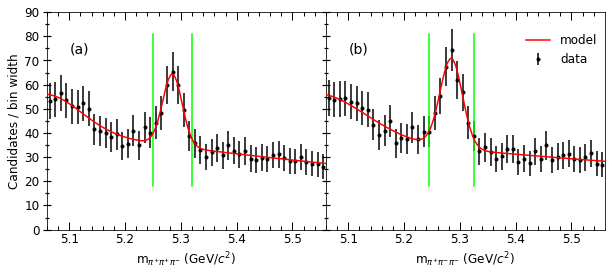

In [25]:
# plot_results(a,bin_centres,bin_centres_red,values,coeff_fit,fname,colour,labels):
# plot_results(ax,mbin_centres_pT,mbin_centres_red_pT,mvalues_pT,mcoeff_pT,'B plus.pdf',
#             colour=['black','red'],labels=[r'$B_{+}$ data', r'$B_{+}$ fit'])
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)
fig.subplots_adjust(wspace=0)
fig.set_facecolor("white")
colour=['black','red']
labels=[r'data', r'model']  

meanm = mcoeff_pT[6]
sdm = np.sqrt(mcoeff_pT[7]) 
meanam = amcoeff_pT[6]
sdam = np.sqrt(amcoeff_pT[7])

#ax1.minorticks_on()
ax1.errorbar(np.array(mbin_centres_pT) / 1000, mvalues_pT,yerr=np.sqrt(mvalues_pT),linestyle='',marker='.',
               markerfacecolor=colour[0],markeredgecolor=colour[0],ecolor=colour[0],label=labels[0],alpha=1)

# plot the fit: create x values, then calculate the corresponding y values and plot
x_fit = np.linspace(mbin_centres_red_pT[0],mbin_centres_red_pT[-1],120)
y_fit = fit_function(x_fit,mcoeff_pT[0],mcoeff_pT[1],mcoeff_pT[2], mcoeff_pT[3], mcoeff_pT[4], 
                     mcoeff_pT[5], mcoeff_pT[6], mcoeff_pT[7])
ax1.plot(x_fit / 1000,y_fit,label=labels[1],color=colour[1],zorder=10) # zorder makes sure the fit line is on top
ax1.set_xlabel(r'$\mathrm{m}_{\pi^{+} \pi^{+} \pi^{-}}$ (GeV/$c^{2}$)', size='large')
ax1.set_ylabel('Candidates / bin width', size='large')

ax1.set_xlim(5.06,5.56)
ax1.set_ylim(0, 90)



ax1.set_xticks(ticks=np.arange(5.06, 5.56, step=0.02), minor=True)
ax1.set_yticks(ticks=np.arange(0, 90, step=5), minor=True)
ax1.xaxis.set_tick_params(width=1, which='major', direction='in', bottom=True, top=True, length=8, labelsize='large')
ax1.xaxis.set_tick_params(width=1, which='minor', direction='in', bottom=True, top=True, length=4)
ax1.yaxis.set_tick_params(width=1.2, which='major', direction='inout', length=8, labelsize='large')
ax1.yaxis.set_tick_params(width=1.2, which='minor', direction='inout', length=4)
ax1.text(5.1, 73, '(a)', fontsize=14)
ax1.axvline((meanm + 2 * sdm) / 1000, 0.2, 0.9, color='lime')
ax1.axvline((meanm - 2 * sdm) / 1000, 0.2, 0.9, color='lime')




#ax2.minorticks_on()
ax2.errorbar(np.array(ambin_centres_pT) / 1000, amvalues_pT,yerr=np.sqrt(amvalues_pT),linestyle='',marker='.',
               markerfacecolor=colour[0],markeredgecolor=colour[0],ecolor=colour[0],label=labels[0],alpha=1)

# plot the fit: create x values, then calculate the corresponding y values and plot
x_fit = np.linspace(ambin_centres_red_pT[0],ambin_centres_red_pT[-1],120)
y_fit = fit_function(x_fit,amcoeff_pT[0],amcoeff_pT[1],amcoeff_pT[2], amcoeff_pT[3], amcoeff_pT[4], 
                     amcoeff_pT[5], amcoeff_pT[6], amcoeff_pT[7])
ax2.plot(x_fit / 1000,y_fit,label=labels[1],color=colour[1],zorder=10) # zorder makes sure the fit line is on top
ax2.set_xlabel(r'$\mathrm{m}_{\pi^{+} \pi^{-} \pi^{-}}$ (GeV/$c^{2}$)', size='large')


ax2.set_xlim(5.06,5.56)
ax2.set_ylim(0, 90)


ax2.set_xticks(ticks=np.arange(5.06, 5.56, step=0.02), minor=True)

ax2.xaxis.set_tick_params(width=1, which='major', direction='in', bottom=True, top=True, length=8, labelsize='large')
ax2.xaxis.set_tick_params(width=1, which='minor', direction='in', bottom=True, top=True, length=4)
ax2.yaxis.set_tick_params(width=1.2, which='major', direction='inout', length=8, labelsize='large')
ax2.yaxis.set_tick_params(width=1.2, which='minor', direction='inout', length=4)
ax2.text(5.1, 73, '(b)', fontsize=14)
ax2.axvline((meanam + 2 * sdam) / 1000, 0.2, 0.9, color='lime')
ax2.axvline((meanam - 2 * sdam) / 1000, 0.2, 0.9, color='lime')
ax2.legend(frameon=False, loc='upper left', bbox_to_anchor=(0.68, 0.95), fontsize='large')

#plt.savefig(fname) #Use for individual plots
#plt.savefig('Combined B mesons.pdf')

#plt.savefig('B- meson and sd.pdf', dpi=600, bbox_inches = "tight")

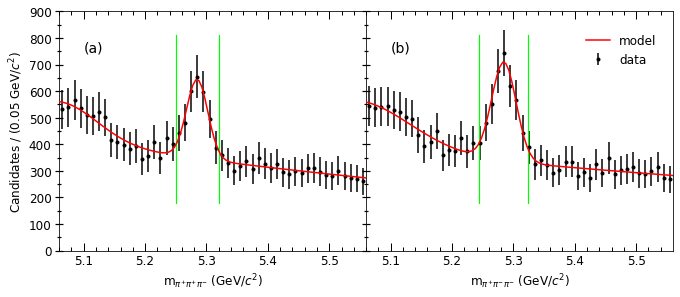

In [30]:
# plot_results(a,bin_centres,bin_centres_red,values,coeff_fit,fname,colour,labels):
# plot_results(ax,mbin_centres_pT,mbin_centres_red_pT,mvalues_pT,mcoeff_pT,'B plus.pdf',
#             colour=['black','red'],labels=[r'$B_{+}$ data', r'$B_{+}$ fit'])
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 4.4), sharey=True)
fig.subplots_adjust(wspace=0)
fig.set_facecolor("white")
colour=['black','red']
labels=[r'data', r'model']  

meanm = mcoeff_pT[6]
sdm = np.sqrt(mcoeff_pT[7]) 
meanam = amcoeff_pT[6]
sdam = np.sqrt(amcoeff_pT[7])

#ax1.minorticks_on()
ax1.errorbar(np.array(mbin_centres_pT) / 1000, np.array(mvalues_pT) * 10,yerr=np.sqrt(mvalues_pT) * 10,linestyle='',marker='.',
               markerfacecolor=colour[0],markeredgecolor=colour[0],ecolor=colour[0],label=labels[0],alpha=1)

# plot the fit: create x values, then calculate the corresponding y values and plot
x_fit = np.linspace(mbin_centres_red_pT[0],mbin_centres_red_pT[-1],120)
y_fit = fit_function(x_fit,mcoeff_pT[0],mcoeff_pT[1],mcoeff_pT[2], mcoeff_pT[3], mcoeff_pT[4], 
                     mcoeff_pT[5], mcoeff_pT[6], mcoeff_pT[7])
ax1.plot(x_fit / 1000,y_fit * 10,label=labels[1],color=colour[1],zorder=10) # zorder makes sure the fit line is on top
ax1.set_xlabel(r'$\mathrm{m}_{\pi^{+} \pi^{+} \pi^{-}}$ (GeV/$c^{2}$)', size='large')
ax1.set_ylabel(r'Candidates / (0.05 GeV/$c^{2}$)', size='large')

ax1.set_xlim(5.06,5.56)
ax1.set_ylim(0, 900)



ax1.set_xticks(ticks=np.arange(5.06, 5.56, step=0.02), minor=True)
ax1.set_yticks(ticks=np.arange(0, 900, step=50), minor=True)
ax1.xaxis.set_tick_params(width=1, which='major', direction='in', bottom=True, top=True, length=8, labelsize='large')
ax1.xaxis.set_tick_params(width=1, which='minor', direction='in', bottom=True, top=True, length=4)
ax1.yaxis.set_tick_params(width=1.2, which='major', direction='inout', length=8, labelsize='large')
ax1.yaxis.set_tick_params(width=1.2, which='minor', direction='inout', length=4)
ax1.text(5.1, 750, '(a)', fontsize=14)
ax1.axvline((meanm + 2 * sdm) / 1000, 0.2, 0.9, color='lime', linewidth=1.2)
ax1.axvline((meanm - 2 * sdm) / 1000, 0.2, 0.9, color='lime', linewidth=1.2)




#ax2.minorticks_on()
ax2.errorbar(np.array(ambin_centres_pT) / 1000, np.array(amvalues_pT) * 10,yerr=np.sqrt(amvalues_pT) * 10,linestyle='',marker='.',
               markerfacecolor=colour[0],markeredgecolor=colour[0],ecolor=colour[0],label=labels[0],alpha=1)

# plot the fit: create x values, then calculate the corresponding y values and plot
x_fit = np.linspace(ambin_centres_red_pT[0],ambin_centres_red_pT[-1],120)
y_fit = fit_function(x_fit,amcoeff_pT[0],amcoeff_pT[1],amcoeff_pT[2], amcoeff_pT[3], amcoeff_pT[4], 
                     amcoeff_pT[5], amcoeff_pT[6], amcoeff_pT[7])
ax2.plot(x_fit / 1000,y_fit * 10,label=labels[1],color=colour[1],zorder=10) # zorder makes sure the fit line is on top
ax2.set_xlabel(r'$\mathrm{m}_{\pi^{+} \pi^{-} \pi^{-}}$ (GeV/$c^{2}$)', size='large')


ax2.set_xlim(5.06,5.56)
ax2.set_ylim(0, 900)


ax2.set_xticks(ticks=np.arange(5.06, 5.56, step=0.02), minor=True)

ax2.xaxis.set_tick_params(width=1, which='major', direction='in', bottom=True, top=True, length=8, labelsize='large')
ax2.xaxis.set_tick_params(width=1, which='minor', direction='in', bottom=True, top=True, length=4)
ax2.yaxis.set_tick_params(width=1.2, which='major', direction='inout', length=8, labelsize='large')
ax2.yaxis.set_tick_params(width=1.2, which='minor', direction='inout', length=4)
ax2.text(5.1, 750, '(b)', fontsize=14)
ax2.axvline((meanam + 2 * sdam) / 1000, 0.2, 0.9, color='lime', linewidth=1.2)
ax2.axvline((meanam - 2 * sdam) / 1000, 0.2, 0.9, color='lime', linewidth=1.2)
ax2.legend(frameon=False, loc='upper left', bbox_to_anchor=(0.68, 0.95), fontsize='large')

#fig.savefig('B meson invariant mass cut.pdf')
#fig.savefig('Curve fit plots', dpi=600)

In [31]:
# Check everything is good
min1 = 5000
max1 = 5600

num = np.where((inv_mass_matter >= min1) & (inv_mass_matter <= max1))
print('Number of invariant mass datapoints between 5000 and 5600 MeV is {0}'.format(len(num[0])))

num_integrate = quad(fit_function, min1, max1, args=(mcoeff_pT[0], mcoeff_pT[1], mcoeff_pT[2], mcoeff_pT[3], 
                                                   mcoeff_pT[4], mcoeff_pT[5], mcoeff_pT[6], mcoeff_pT[7]))
print('Number of invariant mass datapoints between 5000 and 5600 MeV when integrating is {0}'
      .format(num_integrate[0]))
print(len(inv_mass_matter))
print(sdm)
print(sdam)

Number of invariant mass datapoints between 5000 and 5600 MeV is 23840
Number of invariant mass datapoints between 5000 and 5600 MeV when integrating is 23839.481027847145
53266
17.350870931517388
20.000159377061525


### Fitted expression for data

$a_{0}e^{\left(\frac{{-(x-c_{0})}}{b_{0}}\right)} + a_{1}e^{\left(\frac{{-(x-\mu_{1})^{2}}}{\sigma_{sq1}}\right)}
+ a_{2}e^{\left(\frac{{-(x-\mu_{2})^{2}}}{\sigma_{sq2}}\right)}$

Par 1 = $a_{0}$ , Par 2 = $c_{0}$ (fixed) , Par 3 = $b_{0}$

Par 4 = $a_{1}$ , Par 5 = $\mu_{1}$ (fixed) , Par 6 = $\sigma_{sq1}$

Par 7 = $a_{2}$ , Par 8 = $c\mu_{2}$ , Par 9 = $\sigma_{sq2}$

In [32]:
#Calculate A, N+, N-
def A_calc(Nm, Nam):
    N_plus = Nm
    N_minus = Nam
    
    Asym = (N_minus - N_plus)/(N_minus + N_plus)
    Uasym = np.sqrt((1 - Asym ** 2) / (N_minus + N_plus))
    return Asym, Uasym

lim_upper_I = meanm + 1 * sdm
lim_lower_I = meanm - 1 * sdm

lim_upper_a_I = meanam + 1 * sdam
lim_lower_a_I = meanam - 1 * sdam

I = quad(fit_function, lim_lower_I, lim_upper_I, args=(mcoeff_pT[0], mcoeff_pT[1], mcoeff_pT[2], mcoeff_pT[3], 
                                                   mcoeff_pT[4], mcoeff_pT[5], mcoeff_pT[6], mcoeff_pT[7]))
I_a = quad(fit_function, lim_lower_a_I, lim_upper_a_I, args=(amcoeff_pT[0], amcoeff_pT[1], amcoeff_pT[2], amcoeff_pT[3], 
                                                         amcoeff_pT[4], amcoeff_pT[5], amcoeff_pT[6], amcoeff_pT[7]))
# N_plus = 1 / ((np.sqrt(2 * np.pi) * mcoeff_pT[4]))
# N_minus = 1 / ((np.sqrt(2 * np.pi) * amcoeff_pT[4]))

# A_quick = (N_minus - N_plus)/(N_minus + N_plus)
A = (I_a[0] - I[0])/(I_a[0] + I[0])
A_quick = A_calc(mcoeff_pT[4], amcoeff_pT[4])
A_error = np.sqrt((1 - A ** 2) / (I_a[0] + I[0]))
print('Integration A =', A)
print('Integration A uncertainty =', A_error)
print('Normalisation A = {0} +/- {1}'.format(A_quick[0], A_quick[1]))

Integration A = 0.11410417474782539
Integration A uncertainty = 0.014472171642593797
Normalisation A = 0.33210397813586934 +/- 0.008963115504139595


In [33]:
# Calculate area of exponential for background in width range
I_background = quad(exponential, lim_lower_I, lim_upper_I, args=(mcoeff_pT[0], mcoeff_pT[1]))
I_a_background = quad(exponential, lim_lower_a_I, lim_upper_a_I, args=(amcoeff_pT[0], amcoeff_pT[1]))


#I's are the number of counts in the selected region i.e. for exponential function 
#it's the number of counts under that curve

# Calculate total area wanted (i.e. background removed)
I_cut_m = I[0] - I_background[0] 
I_cut_am = I_a[0] - I_a_background[0] 
print('Total number of data points by integration in region 3sd is', I[0])
print('Number of background data points by integration in region 3sd is', I_background[0])
A_fin = (I_cut_am - I_cut_m)/(I_cut_am + I_cut_m)
errorA_fin = np.sqrt((1 - A_fin ** 2)/(I_cut_am + I_cut_m))

number = np.where((inv_mass_matter >= lim_lower_I) & (inv_mass_matter <= lim_upper_I))
print('Number of data points just by using cut offs is', len(number[0]))
print('Integration with background removed, A = {0} +/- {1}'.format(A_fin, errorA_fin))

Total number of data points by integration in region 3sd is 2087.3424565441683
Number of background data points by integration in region 3sd is 1201.1804415732438
Number of data points just by using cut offs is 2104
Integration with background removed, A = 0.18350165747433633 +/- 0.021099306441430172


In [34]:
# Cut off such that only signal events are analysed
indices_sigm = np.where((lim_lower_I <= inv_mass_matter) & (inv_mass_matter <= lim_upper_I)) 
indices_sigam = np.where((lim_lower_a_I <= inv_mass_antimatter) & (inv_mass_antimatter <= lim_upper_a_I)) 

inv_sig_bigm = inv_big_m[indices_sigm]
inv_sig_smallm = inv_small_m[indices_sigm]
inv_sig_bigam = inv_big_am[indices_sigam]
inv_sig_smallam = inv_small_am[indices_sigam]
print(len(inv_sig_bigm))
print((I_cut_m + I_cut_am) / (I_background[0] + I_a_background[0]))

2104
0.8539950061546956


In [27]:
#Removing background data from matter and antimatter for signal events

xm_proxy = meanm + 5 * sdm # for 5 standard deviations you don't have enough data values
xam_proxy =  meanam + 5 * sdam # for 5 standard deviations you don't have enough data values

# ind_back_m = np.where((inv_mass_matter > xm_proxy))
# ind_back_am = np.where((inv_mass_antimatter > xam_proxy))
back_m = inv_mass_matter[np.where((inv_mass_matter > xm_proxy))]
back_am = inv_mass_antimatter[np.where((inv_mass_antimatter > xam_proxy))]

counts_m = int(I_background[0])
counts_am = int(I_a_background[0])

rem_back_m = np.sort(back_m)[counts_m - 1] # for dalitz plot
rem_back_am = np.sort(back_am)[counts_am - 1] # for dalitz plot
print(counts_m)

1201


In [28]:
#background Dalitz removal
proxy_indices_m = np.where((xm_proxy < inv_mass_matter) & (inv_mass_matter < rem_back_m))
proxy_indices_am = np.where((xam_proxy < inv_mass_antimatter) & (inv_mass_antimatter < rem_back_am))
#print(proxy_indices_m)

back_inv_big_m = inv_big_m[proxy_indices_m]
back_inv_small_m =inv_small_m[proxy_indices_m]

back_inv_big_am = inv_big_am[proxy_indices_am]
back_inv_small_am = inv_small_am[proxy_indices_am]
print(len(back_inv_big_m))

1200


### Manipulation of 2D histograms

The following is an example code to demonstrate manipulation of the content of 2D histograms. It first produces two dummy histograms before working out the bin centres, subtracting the histogram contents, and finally plotting. The subtraction bit can of course be replaced by more complex operations as well.

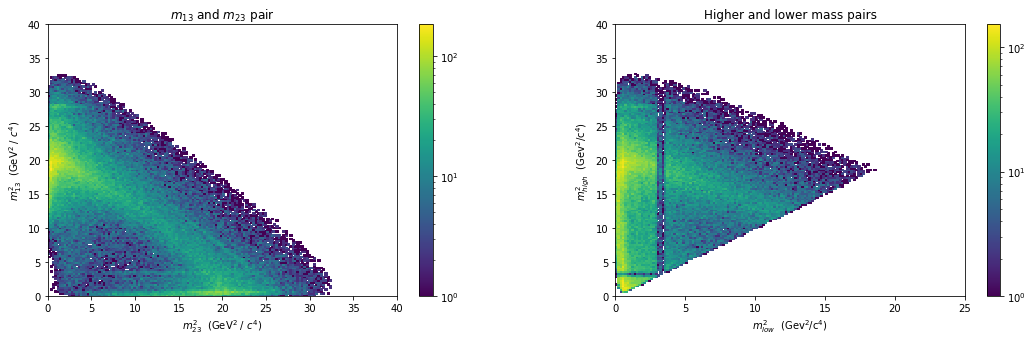

In [29]:
# Dalitz plots of the 2 invariant masses 
# Left - before differentiating between higher and lower 
# Right - after differentiating between higher and lower 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3)

#To the power of 2 and scale to have in GeV^2 form
inv_big_plot = (inv_big_cut / 10 ** 3) ** 2
inv_small_plot = (inv_small_cut / 10 ** 3) ** 2

inv_23 = (inv_mass23 / 10 ** 3) ** 2
inv_13 = (inv_mass13 / 10 ** 3) ** 2


# since the charges 2 and 3 are always the same we can only plot the invariant mass pair for 1,3 and 1,2
h2d1 = ax[0].hist2d(inv_23, inv_13, bins = [150,150], range = [[0,40],[0,40]], norm=colors.LogNorm()) 
ax[0].set_xlabel(r"$m_{23}^{2}$  ($\rm GeV^{2}$ / $c^{4}$)")
ax[0].set_ylabel(r"$m_{13}^{2}$  ($\rm GeV^{2}$ / $c^{4}$)")
ax[0].set_title(r"$m_{13}$ and $m_{23}$ pair")

h2d2 = ax[1].hist2d(inv_small_plot, inv_big_plot, bins = [150,150], range = [[0,25],[0,40]], norm=colors.LogNorm())  
ax[1].set_xlabel(r"$m_{low}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[1].set_ylabel(r"$m_{high}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[1].set_title(r"Higher and lower mass pairs")

fig.colorbar(h2d1[3],ax=ax[0])
fig.colorbar(h2d2[3],ax=ax[1])

#plt.savefig('Initial Dalitz plots.pdf')

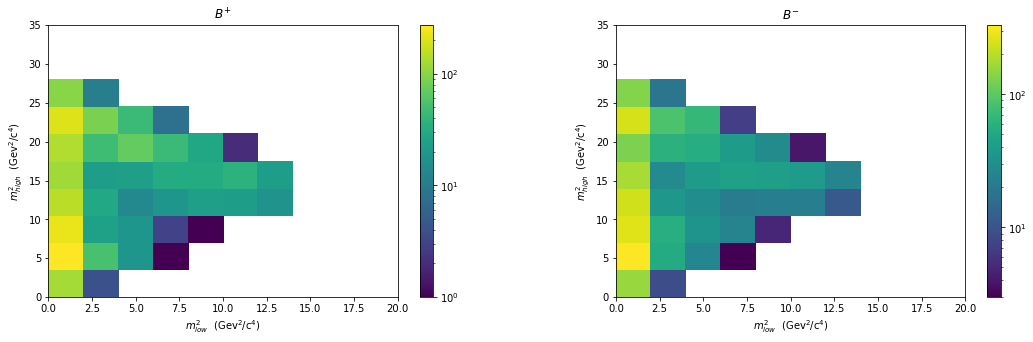

In [30]:
#Dalitz plots of the 2 invariant masses after splitting between B+ and B-
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3)

#To the power of 2 and scale to have in GeV^2 form
inv_bm = (inv_sig_bigm / 10 ** 3) ** 2
inv_sm = (inv_sig_smallm / 10 ** 3) ** 2

inv_bam = (inv_sig_bigam / 10 ** 3) ** 2
inv_sam = (inv_sig_smallam / 10 ** 3) ** 2

# since the charges 2 and 3 are always the same we can only plot the invariant mass pair for 1,3 and 1,2
h2d1_m = ax[0].hist2d(inv_sm, inv_bm, bins = [10,10], range = [[0,20],[0,35]], norm=colors.LogNorm()) 
ax[0].set_xlabel(r"$m_{low}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[0].set_ylabel(r"$m_{high}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[0].set_title(r"$B^{+}$")

h2d2_am = ax[1].hist2d(inv_sam, inv_bam, bins = [10,10], range = [[0,20],[0,35]], norm=colors.LogNorm())  
ax[1].set_xlabel(r"$m_{low}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[1].set_ylabel(r"$m_{high}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[1].set_title(r"$B^{-}$")

fig.colorbar(h2d1_m[3],ax=ax[0])
fig.colorbar(h2d2_am[3],ax=ax[1])

#plt.savefig('B mesons separate plots.pdf')


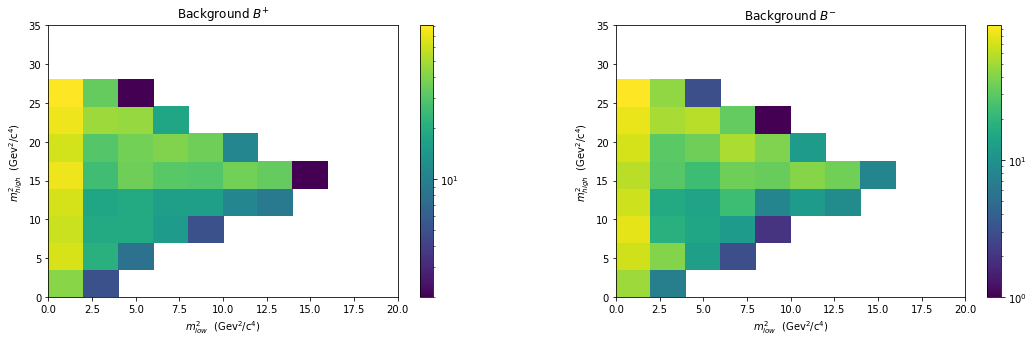

In [31]:
# Plot of background data points for B+ and B- of higher and lowe mass bodies
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3)

#To the power of 2 and scale to have in GeV^2 form
inv_bm_back = (back_inv_big_m / 10 ** 3) ** 2
inv_sm_back = (back_inv_small_m / 10 ** 3) ** 2

inv_bam_back = (back_inv_big_am / 10 ** 3) ** 2
inv_sam_back = (back_inv_small_am / 10 ** 3) ** 2


# since the charges 2 and 3 are always the same we can only plot the invariant mass pair for 1,3 and 1,2
h2d1_mb = ax[0].hist2d(inv_sm_back, inv_bm_back, bins = [10,10], range = [[0,20],[0,35]], norm=colors.LogNorm()) 
ax[0].set_xlabel(r"$m_{low}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[0].set_ylabel(r"$m_{high}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[0].set_title(r"Background $B^{+}$")

h2d2_amb = ax[1].hist2d(inv_sam_back, inv_bam_back, bins = [10,10], range = [[0,20],[0,35]], norm=colors.LogNorm())  
ax[1].set_xlabel(r"$m_{low}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[1].set_ylabel(r"$m_{high}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[1].set_title(r"Background $B^{-}$")

fig.colorbar(h2d1_mb[3],ax=ax[0]) #h2d1[3] returns quadmesh which I guess is for the colorbar
fig.colorbar(h2d2_amb[3],ax=ax[1])

#plt.savefig('Background separate plots.pdf')

Inv_big_m and likewise for small are the same size as inv_mass_matter

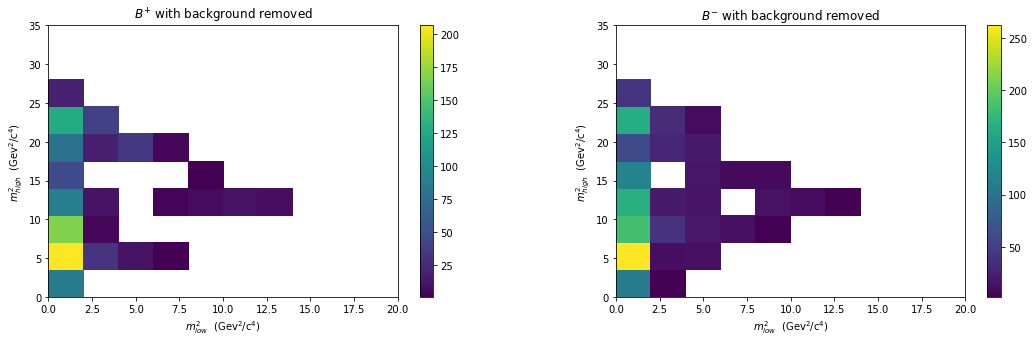

In [32]:
# Dalitz plots of B+ and B- with background removed
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3)

xcentres = []
ycentres = []
for a,b in zip(h2d2_am[1][0:-1],h2d2_am[1][1:]):
    for c,d in zip(h2d2_am[2][0:-1],h2d2_am[2][1:]):
        xcentres.append( (a+b)/2 )
        ycentres.append( (c+d)/2 )

# now extract the weights, that is the bin contents
w1 = (np.array(h2d1_m[0])).flatten() # for matter - background calculation
w2 = (np.array(h2d1_mb[0])).flatten()

w3 = (np.array(h2d2_am[0])).flatten() # for antimatter - background calculation
w4 = (np.array(h2d2_amb[0])).flatten()

wsub1 = np.subtract(w1,w2) # subtract bin content of two histograms
wsub2 = np.subtract(w3,w4)
wsub1[np.where(wsub1<0)] = 0
wsub2[np.where(wsub2<0)] = 0

# produce the new histogram
h2dm = ax[0].hist2d(xcentres,ycentres,weights=wsub1, bins = [h2d1_m[1],h2d1_m[2]],  cmin=0.1) # recycle the binning from above
ax[0].set_xlabel(r"$m_{low}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[0].set_ylabel(r"$m_{high}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[0].set_title(r"$B^{+}$ with background removed")


h2dam = ax[1].hist2d(xcentres,ycentres,weights=wsub2, bins = [h2d2_am[1],h2d2_am[2]], cmin=0.1)
ax[1].set_xlabel(r"$m_{low}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[1].set_ylabel(r"$m_{high}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[1].set_title(r"$B^{-}$ with background removed")

# plot the lot
fig.colorbar(h2dm[3],ax=ax[0]) # let's add the colour scale for histo 1
fig.colorbar(h2dam[3],ax=ax[1]) # let's add the colour scale for histo 2

#plt.savefig('B mesons background removed separate plots better visualisation.pdf')

In [33]:
print(w1)
print(w2)
print(np.subtract(w1,w2))

[128. 272. 228. 152. 121. 141. 201. 100.   0.   0.   4.  53.  24.  29.
  22.  48.  88.  11.   0.   0.   0.  19.  19.  14.  23.  71.  45.   0.
   0.   0.   0.   1.   3.  19.  31.  45.   8.   0.   0.   0.   0.   0.
   1.  23.  31.  28.   0.   0.   0.   0.   0.   0.   0.  22.  37.   2.
   0.   0.   0.   0.   0.   0.   0.  18.  22.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
[42. 65. 60. 64. 74. 63. 74. 81.  0.  0.  5. 21. 19. 18. 26. 30. 47. 34.
  0.  0.  0.  8. 19. 19. 36. 37. 45.  2.  0.  0.  0.  0. 15. 16. 31. 40.
 18.  0.  0.  0.  0.  0.  5. 16. 30. 36.  0.  0.  0.  0.  0.  0.  0. 11.
 37. 11.  0.  0.  0.  0.  0.  0.  0.  9. 34.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 86. 207. 168.  88.  47.  78. 127.  19.   0.   0.  -1.  32.   5.  11.
  -4.  18.  4

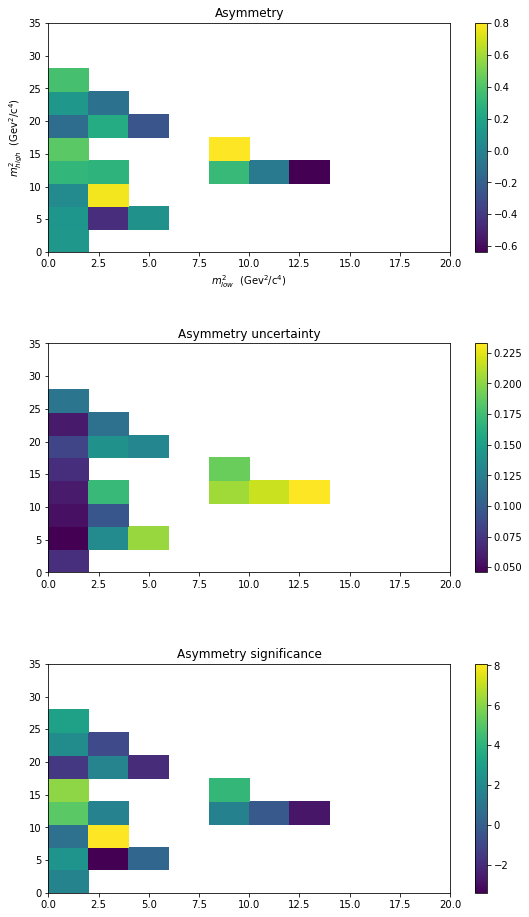

In [34]:
# CP asymmetry calculation - Finds A for each set of data points
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(9, 16))
fig.subplots_adjust(wspace=0.3, hspace=0.4)


xvalues = []
yvalues = []
weights1 = []
weights2 = []
for x in range(100):
    for y in range(100):
        xvalues.append(-10+x/5.+0.1) # bin centre for x
        yvalues.append(-10+y/5.+0.1) # bin centre for y
        weights1.append((x-y))       # weights for histo1, this would be filled automatically
        weights2.append((x-y)+50)    # weights for histo2

        
xcentres = []
ycentres = []
for a,b in zip(h2dm[1][0:-1],h2dm[1][1:]):
    for c,d in zip(h2dm[2][0:-1],h2dm[2][1:]):
        xcentres.append( (a+b)/2 )
        ycentres.append( (c+d)/2 )

# now extract the weights, that is the bin contents
w5 = (np.array(h2dm[0])).flatten() # (matter - background)
w6 = (np.array(h2dam[0])).flatten() # (antimatter - background)

# Asymmetry calculation
wsub5 = np.subtract(w6,w5) # N- - N+
wsub6 = np.add(w6,w5) # N- + N+
w = np.true_divide(wsub5, wsub6)

# Uncertainty calculation
sigma = np.sqrt((1 -  w ** 2) / wsub6)

#Significance calculation
s = np.true_divide(w, sigma)

# produce the new histogram
h2A = ax[0].hist2d(xcentres,ycentres,weights=w, bins = [h2dm[1],h2dm[2]])#, norm=colors.LogNorm()) 
ax[0].set_xlabel(r"$m_{low}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[0].set_ylabel(r"$m_{high}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[0].set_title(r"Asymmetry")

h2sigma = ax[1].hist2d(xcentres,ycentres,weights=sigma, bins = [h2dm[1],h2dm[2]])#, norm=colors.LogNorm()) 
ax[0].set_xlabel(r"$m_{low}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[0].set_ylabel(r"$m_{high}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[1].set_title(r"Asymmetry uncertainty")

h2s = ax[2].hist2d(xcentres,ycentres,weights=s, bins = [h2dm[1],h2dm[2]])#, cmax=8)#, norm=colors.LogNorm()) 
ax[0].set_xlabel(r"$m_{low}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[0].set_ylabel(r"$m_{high}^{2}$  ($\rm Gev^{2} / c^{4}$)")
ax[2].set_title(r"Asymmetry significance")


# plot the lot
fig.colorbar(h2A[3], ax=ax[0]) # let's add the colour scale for histo 1
fig.colorbar(h2sigma[3], ax=ax[1]) # let's add the colour scale for histo 2
fig.colorbar(h2s[3], ax=ax[2]) # let's add the colour scale for histo 3

#plt.savefig('Local asymmetry dalitz plots.pdf')
#Fix that 1 value that crops up dom
#Corrections for A_meas = A_CP + A_detector + A_production only relevant for global asymmetry as local has statistical uncertainties which dominate

In [141]:
# Make the + and - upperscript rather than lowerscript

In [142]:
np.array([1,2], )

array([1, 2])

In [ ]:
#0.11184788414492346 +/- 0.03507814417885819 Magnet up and down averaged